In [3]:
import sys
sys.path.append('.')
import matplotlib.pyplot as plt
%matplotlib notebook


In [4]:
from math import cos, sin
import numpy as np
from TrajectoryGenerator import TrajectoryGenerator
from mpl_toolkits.mplot3d import Axes3D
from Quadrotor import Quadrotor
from drone_3d_trajectory_following import *
import pandas as pd

from mpl_toolkits.mplot3d import Axes3D


In [5]:

show_animation = False

# Simulation parameters
# change for adaptation
g = 9.81
m = 0.2
Ixx = 1
Iyy = 1
Izz = 1
T = 5

# Proportional coefficients
Kp_x = 1
Kp_y = 1
Kp_z = 1
Kp_roll = 25
Kp_pitch = 25
Kp_yaw = 25

# Derivative coefficients
Kd_x = 10
Kd_y = 10
Kd_z = 1


In [6]:
def run():
    """
    Calculates the x, y, z coefficients for the four segments 
    of the trajectory
    """
    x_coeffs = [[], [], [], []]
    y_coeffs = [[], [], [], []]
    z_coeffs = [[], [], [], []]
    waypoints = [[-5, -5, 5], [5, -5, 5], [5, 5, 5], [-5, 5, 5]]

    for i in range(4):
        traj = TrajectoryGenerator(waypoints[i], waypoints[(i + 1) % 4], T)
        traj.solve()
        x_coeffs[i] = traj.x_c
        y_coeffs[i] = traj.y_c
        z_coeffs[i] = traj.z_c
        
    quad_sim(x_coeffs, y_coeffs, z_coeffs)


In [7]:

def quad_sim_trajectory(x_c, y_c, z_c, T, pos=None):
    """
    Calculates the necessary thrust and torques for the quadrotor to
    follow the trajectory described by the sets of coefficients
    x_c, y_c, and z_c.
    """
    if pos:
        x_pos = pos[0]
        y_pos = pos[1]
        z_pos = pos[2]
    else: 
        x_pos = 0
        y_pos = 0
        z_pos = 0
    x_vel = 0
    y_vel = 0
    z_vel = 0
    x_acc = 0
    y_acc = 0
    z_acc = 0
    roll = 0
    pitch = 0
    yaw = 0
    roll_vel = 0
    pitch_vel = 0
    yaw_vel = 0

    des_yaw = 0

    dt = 0.1
    t = 0

    q = Quadrotor(x=x_pos, y=y_pos, z=z_pos, roll=roll,
                  pitch=pitch, yaw=yaw, size=1, show_animation=show_animation)

    i = 0
    n_run = 4
    irun = 0
    
    trajectory = []
    
    for i in range(len(x_c)):
        while t <= T:
            des_x_pos = calculate_position(x_c[i], t)
            des_y_pos = calculate_position(y_c[i], t)
            des_z_pos = calculate_position(z_c[i], t)
            des_x_vel = calculate_velocity(x_c[i], t)
            des_y_vel = calculate_velocity(y_c[i], t)
            des_z_vel = calculate_velocity(z_c[i], t)
            des_x_acc = calculate_acceleration(x_c[i], t)
            des_y_acc = calculate_acceleration(y_c[i], t)
            des_z_acc = calculate_acceleration(z_c[i], t)

            thrust = m * (g + des_z_acc + Kp_z * (des_z_pos -
                                                  z_pos) + Kd_z * (des_z_vel - z_vel))

            roll_torque = Kp_roll * \
                (((des_x_acc * sin(des_yaw) - des_y_acc * cos(des_yaw)) / g) - roll)
            pitch_torque = Kp_pitch * \
                (((des_x_acc * cos(des_yaw) - des_y_acc * sin(des_yaw)) / g) - pitch)
            yaw_torque = Kp_yaw * (des_yaw - yaw)
            
            #print(roll_torque,pitch_torque,yaw_torque)

            roll_vel += roll_torque * dt / Ixx
            pitch_vel += pitch_torque * dt / Iyy
            yaw_vel += yaw_torque * dt / Izz

            roll += roll_vel * dt
            pitch += pitch_vel * dt
            yaw += yaw_vel * dt

            R = rotation_matrix(roll, pitch, yaw)
            acc = (np.matmul(R, np.array(
                [0, 0, thrust.item()]).T) - np.array([0, 0, m * g]).T) / m
            x_acc = acc[0]
            y_acc = acc[1]
            z_acc = acc[2]
            x_vel += x_acc * dt
            y_vel += y_acc * dt
            z_vel += z_acc * dt
            x_pos += x_vel * dt
            y_pos += y_vel * dt
            z_pos += z_vel * dt

            q.update_pose(x_pos, y_pos, z_pos, roll, pitch, yaw)
            trajectory.append([x_pos, y_pos, z_pos, roll, pitch, yaw])
            t += dt

        t = 0
        #i = (i + 1) % 4
        #irun += 1
        #if irun >= n_run:
        #    break

    print("Done")
    return trajectory, q


In [8]:


waypoints = [[-5, -5, 5], [5, -5, 5], [5, 5, 5],[5, 5, 5]]

coef_len = len(waypoints)-1
x_coeffs = [[]]*coef_len
y_coeffs = [[]]*coef_len
z_coeffs = [[]]*coef_len

for i in range(len(waypoints)-1):
    traj = TrajectoryGenerator(waypoints[i], waypoints[(i + 1)], T)
    traj.solve()
    x_coeffs[i] = traj.x_c
    y_coeffs[i] = traj.y_c
    z_coeffs[i] = traj.z_c



In [9]:

traj, q = quad_sim_trajectory(x_coeffs, y_coeffs, z_coeffs, 8)
traj = np.array(traj)

Done


/var/folders/h2/p2n4nzc90zb6lngs5bgtd6sc0000gn/T/ipykernel_18267/3734488126.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  traj = np.array(traj)


# A star
ref: AtsushiSakai/PythonRobotics


In [10]:
import math

In [30]:

class AStarPlanner:

    def __init__(self, ox, oy, oz, resolution, rr):
        """
        Initialize grid map for a star planning
        ox: x position list of Obstacles [m]
        oy: y position list of Obstacles [m]
        oz: z position list of Obstacles [m]
        resolution: grid resolution [m]
        rr: robot radius[m]
        """

        self.resolution = resolution
        self.rr = rr
        self.min_x, self.min_y, self.min_z = 0, 0, 0
        self.max_x, self.max_y,self.max_z = 7, 7, 7
        self.obstacle_map = None
        self.x_width, self.y_width , self.z_width = 0, 0, 0
        self.motion = self.get_motion_model()
        self.calc_obstacle_map(ox, oy, oz)

    class Node:
        def __init__(self, x, y, z, cost, parent_index):
            self.x = x  # index of grid
            self.y = y  # index of grid
            self.z = z
            self.cost = cost
            self.parent_index = parent_index

        def __str__(self):
            return str(self.x) + "," + str(self.y) + "," + str(self.z) + "," + str(
                self.cost) + "," + str(self.parent_index)

    def planning(self, sx, sy, sz, gx, gy, gz):
        """
        A star path search
        input:
            s_x: start x position [m]
            s_y: start y position [m]
            gx: goal x position [m]
            gy: goal y position [m]
        output:
            rx: x position list of the final path
            ry: y position list of the final path
        """

        start_node = self.Node(self.calc_xy_index(sx, self.min_x), 
                               self.calc_xy_index(sy, self.min_y),
                               self.calc_xy_index(sz, self.min_z), 0.0, -1)
        goal_node = self.Node(self.calc_xy_index(gx, self.min_x),
                              self.calc_xy_index(gy, self.min_y),
                              self.calc_xy_index(gz, self.min_z), 0.0, -1)

        open_set, closed_set = dict(), dict()
        open_set[self.calc_grid_index(start_node)] = start_node

        while 1:
            if len(open_set) == 0:
                print("Open set is empty..")
                break
           
            c_id = min(
                open_set,
                key=lambda o: open_set[o].cost + self.calc_heuristic(goal_node,
                                                                     open_set[o]))
            current = open_set[c_id]
            
            if current.x == goal_node.x and current.y == goal_node.y and current.z == goal_node.z:
                print("Goal Found")
                goal_node.parent_index = current.parent_index
                goal_node.cost = current.cost
                break

            # Remove the item from the open set
            del open_set[c_id]

            # Add it to the closed set
            closed_set[c_id] = current

            # expand_grid search grid based on motion model
            for i, _ in enumerate(self.motion):
                node = self.Node(int(current.x + self.motion[i][0]),
                                 int(current.y + self.motion[i][1]),
                                 int(current.z + self.motion[i][2]), current.cost + self.motion[i][3], c_id)
                n_id = self.calc_grid_index(node)

                # If the node is not safe, do nothing
                if not self.verify_node(node):
                    continue

                if n_id in closed_set:
                    continue

                if n_id not in open_set:
                    open_set[n_id] = node  # discovered a new node
                else:
                    if open_set[n_id].cost > node.cost:
                        # This path is the best until now. record it
                        open_set[n_id] = node

        rx, ry, rz = self.calc_final_path(goal_node, closed_set)

        return rx, ry, rz

    def calc_final_path(self, goal_node, closed_set):
        # generate final course
        rx, ry, rz = [self.calc_grid_position(goal_node.x, self.min_x)], \
                     [self.calc_grid_position(goal_node.y, self.min_y)], \
                     [self.calc_grid_position(goal_node.z, self.min_z)]
        parent_index = goal_node.parent_index
        
        while parent_index != -1:
            n = closed_set[parent_index]
            rx.append(self.calc_grid_position(n.x, self.min_x))
            ry.append(self.calc_grid_position(n.y, self.min_y))
            rz.append(self.calc_grid_position(n.z, self.min_z))

            parent_index = n.parent_index

        return rx, ry, rz

    @staticmethod
    def calc_heuristic(n1, n2):
        w = 1.0  # weight of heuristic
        d = w * math.hypot(n1.x - n2.x, n1.y - n2.y, n1.z - n2.z)
        return d

    def calc_grid_position(self, index, min_position):
        """
        calc grid position
        :param index:
        :param min_position:
        :return:
        """
        pos = index * self.resolution + min_position
        return pos

    def calc_xy_index(self, position, min_pos):
        return round((position - min_pos) / self.resolution)

    def calc_grid_index(self, node):
        return (node.z - self.min_z) * (self.x_width * self.y_width) + \
               (node.y - self.min_y) * self.x_width + (node.x - self.min_x)

    def verify_node(self, node):
        px = self.calc_grid_position(node.x, self.min_x)
        py = self.calc_grid_position(node.y, self.min_y)
        pz = self.calc_grid_position(node.z, self.min_z)

        if px < self.min_x:
            return False
        elif py < self.min_y:
            return False
        elif pz < self.min_z:
            return False
        elif px >= self.max_x:
            return False
        elif py >= self.max_y:
            return False
        elif pz >= self.max_z:
            return False


        # collision check
        if self.obstacle_map[node.x][node.y][node.z]:
            return False

        return True

    def calc_obstacle_map(self, ox, oy, oz):

        # set min max and width for x, y, z respectively
        for dim in ['x','y','z']:
            #setattr(self, 'min_' + dim, round(min(vars()['o'+dim])))
            #setattr(self, 'max_' + dim, round(max(vars()['o'+dim])))
            
            width = (getattr(self, 'max_x') - getattr(self, 'min_x')) / self.resolution
            setattr(self, dim + '_width', round(width))

            #print('min_'+dim, getattr(self, 'min_' + dim))
            #print('max_'+dim, getattr(self, 'max_' + dim))
            #print(dim+'_width', getattr(self, dim+'_width'))


        # obstacle map generation
        self.obstacle_map = [[[False for _ in range(self.y_width)]
                             for _ in range(self.x_width)] 
                             for _ in range(self.z_width)]
        for ix in range(self.x_width):
            x = self.calc_grid_position(ix, self.min_x)
            for iy in range(self.y_width):
                y = self.calc_grid_position(iy, self.min_y)
                for iz in range(self.z_width):
                    z =  self.calc_grid_position(iz, self.min_z)
                    for iox, ioy, ioz in zip(ox, oy, oz):
                        d = math.hypot(iox - x, ioy - y, ioz - z)
                        if d <= self.rr:
                            self.obstacle_map[ix][iy][iz] = True
                            break

    @staticmethod
    def get_motion_model():
        # dx, dy, dz, cost
        # array([[ 1.,  0.,  0.,  1.],
        #        [ 0.,  1.,  0.,  1.],
        #        [ 0.,  0.,  1.,  1.],
        #        [-1., -0., -0.,  1.],
        #        [-0., -1., -0.,  1.],
        #        [-0., -0., -1.,  1.]])
        a = np.concatenate([np.eye(3), -1*np.eye(3)])
        motion = np.concatenate([a, np.ones((6,1))], axis = 1)

        return motion


In [178]:

# start and goal position
sx, sy, sz = 0,0,0  # [m]
gx, gy, gz = 5,5,5  # [m]
grid_size = 0.5  # [m]
robot_radius = 1  # [m]

# set obstacle positions
ox, oy, oz = [], [], []
for i in np.linspace(1,4,8):
    for j in np.linspace(1,4,8):
        for k in np.linspace(1,4,8):
            ox.append(i)
            oy.append(j)
            oz.append(k)
            
a_star = AStarPlanner(ox, oy, oz, grid_size, robot_radius)
rx, ry, rz = a_star.planning(sx, sy, sz, gx, gy, gz)


Goal Found


In [179]:
waypoints = list(zip(rx, ry, rz))
waypoints = waypoints[::-1]

In [180]:

axes = [6, 6, 6]
obstacles = np.zeros(axes, dtype=np.bool)
for i in range(1,3):
    for j in range(1,3):
        for k in range(1,3):
            obstacles[i,j,k]=True

# for coord in zip(ox,oy,oz):  
#     obstacles[coord[0], coord[1], coord[2]]=True

/var/folders/h2/p2n4nzc90zb6lngs5bgtd6sc0000gn/T/ipykernel_12147/1914323466.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  obstacles = np.zeros(axes, dtype=np.bool)


In [181]:
waypoints[0],  waypoints[(1)], T

((0.0, 0.0, 0.0), (0.5, 0.0, 0.0), 5)

In [182]:

#waypoints = [[-5, -5, 5], [5, -5, 5], [5, 5, 5],[5, 5, 5]]
def sim_traj(waypoints, T=5):
    coef_len = len(waypoints)-1
    x_coeffs = [[]]*coef_len
    y_coeffs = [[]]*coef_len
    z_coeffs = [[]]*coef_len

    for i in range(len(waypoints)-1):
        traj = TrajectoryGenerator(waypoints[i], waypoints[(i + 1)], T)
        traj.solve()
        x_coeffs[i] = traj.x_c
        y_coeffs[i] = traj.y_c
        z_coeffs[i] = traj.z_c

    traj, q = quad_sim_trajectory(x_coeffs, y_coeffs, z_coeffs, T, pos=waypoints[0])
    traj = np.array(traj)
    return traj

In [191]:
waypoints

[(0.0, 0.0, 0.0),
 (0.5, 0.0, 0.0),
 (0.5, 0.5, 0.0),
 (1.0, 0.5, 0.0),
 (1.5, 0.5, 0.0),
 (2.0, 0.5, 0.0),
 (2.5, 0.5, 0.0),
 (3.0, 0.5, 0.0),
 (3.5, 0.5, 0.0),
 (4.0, 0.5, 0.0),
 (4.5, 0.5, 0.0),
 (5.0, 0.5, 0.0),
 (5.0, 0.5, 0.5),
 (5.0, 1.0, 0.5),
 (5.0, 1.5, 0.5),
 (5.0, 1.5, 1.0),
 (5.0, 1.5, 1.5),
 (5.0, 2.0, 1.5),
 (5.0, 2.0, 2.0),
 (5.0, 2.5, 2.0),
 (5.0, 2.5, 2.5),
 (5.0, 3.0, 2.5),
 (5.0, 3.0, 3.0),
 (5.0, 3.5, 3.0),
 (5.0, 3.5, 3.5),
 (5.0, 4.0, 3.5),
 (5.0, 4.5, 3.5),
 (5.0, 4.5, 4.0),
 (5.0, 4.5, 4.5),
 (5.0, 5.0, 4.5),
 (5.0, 5.0, 5.0)]

In [194]:
traj = sim_traj(waypoints, T=4)

Done


/var/folders/h2/p2n4nzc90zb6lngs5bgtd6sc0000gn/T/ipykernel_12147/494297335.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  traj = np.array(traj)


<IPython.core.display.Javascript object>


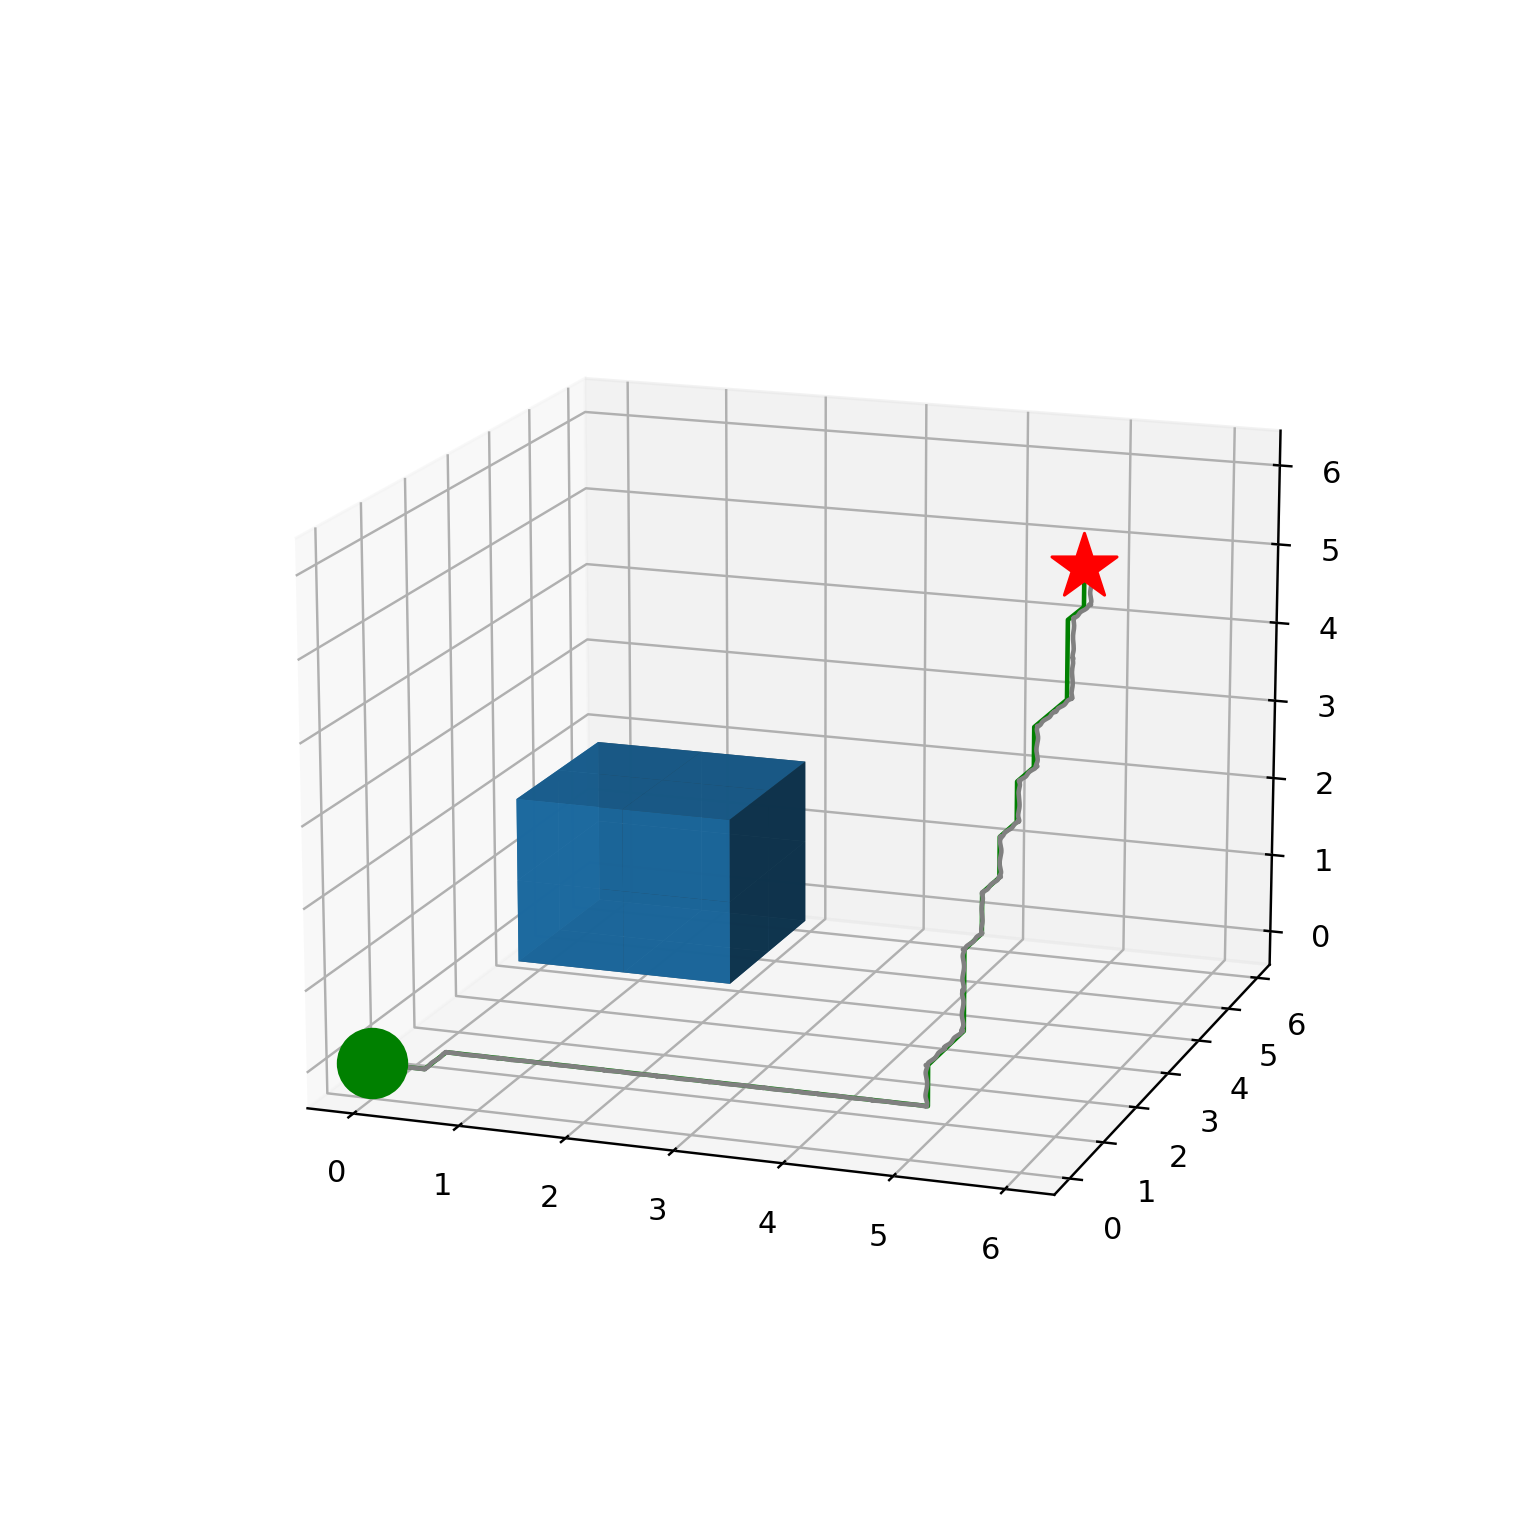

In [195]:
fig = plt.figure(figsize=(7,7))
ax = plt.axes(projection='3d')

# obstacles
alpha = 0.9

ax.voxels(obstacles, alpha=alpha)

# planned path
ax.plot3D(rx, ry, rz, 'green')
ax.scatter3D(sx, sy, sz,  c= 'g', marker="o", s=500)
ax.scatter3D(gx, gy, gz,  c= 'r', marker="*", s=500)

# sim path
ax.plot3D(traj[:,0], traj[:,1], traj[:,2], 'gray')
#ax.scatter3D(traj[:,0], traj[:,1], traj[:,2],  c= traj[:,2], cmap='Blues')


f(s,a) = s'

a* s_t -> s_{t+1}
f(s_t, a*) = s_{t+1}


f(s_t, a*)

f(s_t, a*) + f'(s_t, a*) f' is unknown
f'(s_t, a*) = N(m,u) is noise

MPC setting
write down the overleaf somewhere 
what are we predicting
why do we want uncertainty


previous model on trajectory prediction
controller generates p(a|s)
 p(s|s', a) 

planning for exter

model predictive setting.


In [ ]:
planed waypoints -> controls
controls -> dynamics (Unknown) -> acutal trajectory


predict P(acutal trajectory | planed waypoints)

In [ ]:
s_t | planned trajectory
s_t = f(t) = planned(t)

s_t_actual - s_t


In [ ]:
p(s|s')

p(s|s',a)

In [ ]:
after agent is at s'_t

# Make predictive model

In [496]:
sx, sy, sz = np.random.rand(3)*5

In [103]:
all_errs = []

for k in range(200):
    # start and goal position
    sx, sy, sz = np.random.rand(3)*5  # [m]
    gx, gy, gz = np.random.rand(3)*5  # [m]
    grid_size = 0.5  # [m]
    robot_radius = 1 # [m]

    # set obstacle positions
    ox, oy, oz = [], [], []

    a_star = AStarPlanner(ox, oy, oz, grid_size, robot_radius)
    rx, ry, rz = a_star.planning(sx, sy, sz, gx, gy, gz)
    waypoints = list(zip(rx, ry, rz))
    waypoints = waypoints[::-1]
    traj = sim_traj(waypoints, T=3)

    errs = [np.linalg.norm(traj[30*i][:3] - waypoints[i]) for i in range(len(waypoints)-1)]
    all_errs.append(errs)

Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done


/var/folders/h2/p2n4nzc90zb6lngs5bgtd6sc0000gn/T/ipykernel_12147/494297335.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  traj = np.array(traj)


Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Fou

In [104]:
maxlen = max([len(k) for k in all_errs])
maxlen

20

In [105]:
nonconformity = []

for i in range(maxlen):
    i_err = []
    for err in all_errs:
        if len(err) > i:
            i_err.append(err[i])
    nonconformity.append(i_err)

In [106]:
n_calibration = len(all_errs)
epsilon = 0.1
new_quantile = min((n_calibration + 1.0) * (1 - epsilon) / n_calibration, 1)     

radius = [np.quantile(nonconformity[r], new_quantile) for r in range(len(nonconformity))]

In [107]:
new_quantile

0.9045000000000001

In [108]:
radius

[0.0,
 0.01657764404680712,
 0.016442883726581387,
 0.017099578312853733,
 0.03138829950472674,
 0.031014297313090508,
 0.04723504424381591,
 0.06518563665589425,
 0.10433080264343263,
 0.12274627970181426,
 0.19279703007494756,
 0.2337162298389101,
 0.2763290373956631,
 0.39950516572912154,
 0.40536567253576505,
 0.44437323503290604,
 0.5344797472792532,
 0.6112656753938509,
 0.6393074569000821,
 0.2573773714102424]

# test

In [173]:
all_errs = []
volumes = []

bigT = 3 
for k in range(100):
    # start and goal position
    sx, sy, sz = np.random.rand(3)*5  # [m]
    gx, gy, gz = np.random.rand(3)*5  # [m]
    grid_size = 0.5  # [m]
    robot_radius = 1 # [m]

    # set obstacle positions
    ox, oy, oz = [], [], []

    a_star = AStarPlanner(ox, oy, oz, grid_size, robot_radius)
    rx, ry, rz = a_star.planning(sx, sy, sz, gx, gy, gz)
    waypoints = list(zip(rx, ry, rz))
    waypoints = waypoints[::-1]
    traj = sim_traj(waypoints, T=bigT)

    errs = [np.linalg.norm(traj[10*bigT*i][:3] - waypoints[i]) 
            for i in range(len(waypoints)-1)]
    all_errs.append(errs)
    
    volumes.append( sum([4/3* np.pi * (r**3) for r in radius[:len(waypoints)]]))

Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found


/var/folders/h2/p2n4nzc90zb6lngs5bgtd6sc0000gn/T/ipykernel_12147/494297335.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  traj = np.array(traj)


Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goa

In [175]:
np.mean(volumes)

0.5795359091474803

In [159]:
cov = []

for e in all_errs:
    cov.append( [e[i] <= radius[i] if i < len(radius) else 0 for i in range(len(e))])

np.mean(np.concatenate(cov), axis=0)

0.9308755760368663

In [156]:
vol = sum([4/3* np.pi * (r**3) for r in radius])
vol

3.8621539435785555

In [153]:
for i in range(10):
    covs_at_i = []
    for c in cov:
        if len(c) > i:
            covs_at_i.append(c[i])
    rate = np.mean(covs_at_i)
    print(rate)

1.0
0.94
0.9387755102040817
0.9148936170212766
0.8901098901098901
0.896551724137931
0.9285714285714286
0.8552631578947368
0.8813559322033898
0.8571428571428571


## if given more time, for example

In [160]:
all_errs_4 = []

bigT = 4

areas = []
for k in range(100):
    # start and goal position
    sx, sy, sz = np.random.rand(3)*5  # [m]
    gx, gy, gz = np.random.rand(3)*5  # [m]
    grid_size = 0.5  # [m]
    robot_radius = 1 # [m]

    # set obstacle positions
    ox, oy, oz = [], [], []

    a_star = AStarPlanner(ox, oy, oz, grid_size, robot_radius)
    rx, ry, rz = a_star.planning(sx, sy, sz, gx, gy, gz)
    waypoints = list(zip(rx, ry, rz))
    waypoints = waypoints[::-1]
    traj = sim_traj(waypoints, T=bigT)

    errs = [np.linalg.norm(traj[10*bigT*i][:3] - waypoints[i]) for i in range(len(waypoints)-1)]
    
    
    
    all_errs_4.append(errs)
    

Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found


/var/folders/h2/p2n4nzc90zb6lngs5bgtd6sc0000gn/T/ipykernel_12147/494297335.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  traj = np.array(traj)


Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goal Found
Done
Goa

In [162]:
cov = []

for e in all_errs_4:
    cov.append( [e[i] <= radius[i] if i < len(radius) else 0 for i in range(len(e))])

np.mean(np.concatenate(cov), axis=0)

0.997090203685742

In [169]:
adjust_quantile = 0.4
new_radius = [np.quantile(nonconformity[r], adjust_quantile) 
              for r in range(len(nonconformity))]

In [170]:
cov = []

for e in all_errs_4:
    cov.append( [e[i] <= new_radius[i] if i < len(radius) else 0 for i in range(len(e))])

np.mean(np.concatenate(cov), axis=0)

0.9466537342386033

In [171]:
vol = sum([4/3* np.pi * (r**3) for r in new_radius])
vol

0.16212204212889678